# Implementation of GAN for MNIST digit generation for Sony CSL internship

This is a simple implementation of a GAN, cGAN and e-cGAN in pytorch for MNIST digit generation


## Requirements

We begin by importing the required libraries and the MNIST dataset, while defining the key global hyperparameters


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64
lr = 0.0002
real_val = 1
fake_val = 0
device = torch.device("mps")

mnist = MNIST(root="data", train=True, download=True, 
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=2)

Next we'll just print some examples of the MNIST dataset to see what we're working with

In [ ]:
examples = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(examples[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Vanilla Generative Adversarial Network (GAN)


In [4]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel

        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel

        self.model = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)#.view(-1, 1).squeeze(1)

In [22]:
generator = Generator(64, 100, 1).to(device)
print(generator)
discriminator = Discriminator(64, 1).to(device)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (11): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [7]:
loss = nn.BCELoss()

dis_optimiser = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
gen_optimiser = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

test_noise = torch.randn(batch_size, 100, device=device)

In [8]:
def dis_train_step(batch_size, gen, dis, disoptimiser, loss, real_img):
    disoptimiser.zero_grad()  # Clear the gradients of the conditional discriminator optimizer

    validity = dis(real_img)  # Get the validity scores of the real images from the conditional discriminator
    real_loss = loss(validity, torch.full((batch_size,), real_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the real images
    
    noise = torch.randn(batch_size, 100, device=device)  # Generate random noise
    fake = gen(noise)  # Generate fake images using the conditional generator
    validity = dis(fake.detach())  # Get the validity scores of the fake images from the conditional discriminator
    fake_loss = loss(validity, torch.full((batch_size,), fake_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the fake images

    dloss = real_loss + fake_loss  # Calculate the total loss for the conditional discriminator
    dloss.backward()  # Backpropagate the gradients
    disoptimiser.step()  # Update the conditional discriminator parameters using the optimizer
    return dloss.item()  # Return the loss value as a scalar

In [9]:
def gen_train_step(batch_size, gen, dis, genoptimiser, loss):
    genoptimiser.zero_grad()  # Clear the gradients of the conditional generator optimizer

    noise = torch.randn(batch_size, 100, device=device)  # Generate random noise
    
    fake = gen(noise)  # Generate fake images using the conditional generator
    validity = dis(fake)  # Get the validity scores of the fake images from the conditional discriminator
    gloss = loss(validity, torch.full((batch_size,), real_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the conditional generator

    gloss.backward()  # Backpropagate the gradients
    genoptimiser.step()  # Update the conditional generator parameters using the optimizer
    return gloss.item()  # Return the loss value as a scalar

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 5

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 100, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_val)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        disOptimiser.step()

        # (3) Update the generator with fake data
        generator.zero_grad()
        label.fill_(real_val)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        genOptimiser.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(test_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
# Determine the grid size
grid_size = int(np.ceil(np.sqrt(len(img_list))))

# Create a new figure
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Iterate over all images and plot them
for i, img in enumerate(img_list):
    ax = axs[i // grid_size, i % grid_size]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f'Step {(i+1)*500}')  # Add title with image number
    ax.axis('off')

# If there are less images than grid cells, remove the empty plots
if len(img_list) < grid_size**2:
    for i in range(len(img_list), grid_size**2):
        fig.delaxes(axs.flatten()[i])

# Show the plot
plt.show()

In [ ]:
import pandas as pd

# Convert lists to pandas Series
G_losses_pd = pd.Series(G_losses)
D_losses_pd = pd.Series(D_losses)

# Calculate moving averages
window_size = 50  # Define the size of the moving average window
G_losses_smooth = G_losses_pd.rolling(window_size).mean()
D_losses_smooth = D_losses_pd.rolling(window_size).mean()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")

# Plot original losses in faded color
plt.plot(G_losses, label="G", color='skyblue')
plt.plot(D_losses, label="D", color='lightcoral')

# Plot moving averages in solid color
plt.plot(G_losses_smooth, label="G Smooth", color='blue')
plt.plot(D_losses_smooth, label="D Smooth", color='red')

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Conditional GAN (cGAN)

We will encode our classes as embedding layers then scale them using a linear layer to act as a separate image channel.

In [10]:
class ConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input [batch, latent_dim, channels]
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)

In [11]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Linear(49, 784),
            nn.Unflatten(1, (1, 28, 28))
        )

        self.downsample = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel + 1, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.label_embedding(y)
        x = torch.cat((x, y), dim=1)
        return self.downsample(x)

In [12]:
cgenerator = ConditionalGenerator(64, 100, 1, 10).to(device)
print(cgenerator)
cdiscriminator = ConditionalDiscriminator(64, 1, 10).to(device)
print(cdiscriminator)

cdis_optimiser = torch.optim.Adam(cdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
cgen_optimiser = torch.optim.Adam(cgenerator.parameters(), lr=lr, betas=(0.5, 0.999))

ConditionalGenerator(
  (label_embedding): Sequential(
    (0): Embedding(10, 49)
    (1): Unflatten(dim=1, unflattened_size=(1, 7, 7))
  )
  (reshape_noise): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(257, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (7): Tanh()
  )
)
ConditionalD

In [13]:
def cdis_train_step(batch_size, cgen, cdis, cdisoptimiser, loss, real_img, labels):
    cdisoptimiser.zero_grad()  # Clear the gradients of the conditional discriminator optimizer

    validity = cdis(real_img, labels)  # Get the validity scores of the real images from the conditional discriminator
    real_loss = loss(validity, torch.full((batch_size,), real_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the real images
    
    noise = torch.randn(batch_size, 100, device=device)  # Generate random noise
    fake_labels = torch.randint(0, 10, (batch_size,), device=device)  # Generate random labels
    fake = cgen(noise, fake_labels)  # Generate fake images using the conditional generator
    validity = cdis(fake.detach(), fake_labels)  # Get the validity scores of the fake images from the conditional discriminator
    fake_loss = loss(validity, torch.full((batch_size,), fake_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the fake images

    cdloss = real_loss + fake_loss  # Calculate the total loss for the conditional discriminator
    cdloss.backward()  # Backpropagate the gradients
    cdisoptimiser.step()  # Update the conditional discriminator parameters using the optimizer
    return cdloss.item()  # Return the loss value as a scalar

In [14]:
def cgen_train_step(batch_size, cgen, cdis, cgenoptimiser, loss):
    cgenoptimiser.zero_grad()  # Clear the gradients of the conditional generator optimizer

    noise = torch.randn(batch_size, 100, device=device)  # Generate random noise
    labels = torch.randint(0, 10, (batch_size,), device=device)  # Generate random labels
    
    fake = cgen(noise, labels)  # Generate fake images using the conditional generator
    validity = cdis(fake, labels)  # Get the validity scores of the fake images from the conditional discriminator
    cgloss = loss(validity, torch.full((batch_size,), real_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the conditional generator

    cgloss.backward()  # Backpropagate the gradients
    cgenoptimiser.step()  # Update the conditional generator parameters using the optimizer
    return cgloss.item()  # Return the loss value as a scalar

In [ ]:
num_epochs = 10
test_noise = torch.randn(10, 100, device=device)
test_labels = torch.LongTensor(np.arange(10)).to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    for i, (images, label) in enumerate(dataloader):
        real_img = images.to(device)
        labels = label.to(device)
        cgenerator.train()
        batch_size = real_img.shape[0]
        cdis_loss = cdis_train_step(batch_size, cgenerator, cdiscriminator, cdis_optimiser, loss, real_img, labels)
        cgen_loss = cgen_train_step(batch_size, cgenerator, cdiscriminator, cgen_optimiser, loss)
        if i % 50 == 0:
            print('Step: {}/{}, g_loss: {}, d_loss: {}'.format(i, len(dataloader), cgen_loss, cdis_loss), end='\x1b[1K\r')

    cgenerator.eval()
    print('Final: g_loss: {}, d_loss: {}'.format(cgen_loss, cdis_loss)) # Print the loss values
    sample_images = cgenerator(test_noise, test_labels).cpu()
    grid = torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

## Encoder Conditional GAN (e-cGAN) Implementation

In [15]:
class EncoderConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel

        # Encoder that produces a 100-dimensional latent vector from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, latent_dim)
        ) 

        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        z = self.encoder(z)
        return self.model(z)

In [36]:
ecgenerator = EncoderConditionalGenerator(64, 50, 1).to(device)
print(ecgenerator)
ecdiscriminator = Discriminator(64, 1).to(device)
print(discriminator)

EncoderConditionalGenerator(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=50, bias=True)
  )
  (model): Sequential(
    (0): Linear(in_features=50, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2

In [17]:
def ecdis_train_step(batch_size, ecgen, dis, ecdisoptimiser, loss, real_img):
    ecdisoptimiser.zero_grad()  # Clear the gradients of the conditional discriminator optimizer

    validity = dis(real_img)  # Get the validity scores of the real images from the conditional discriminator
    real_loss = loss(validity, torch.full((batch_size,), real_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the real images
    
    fake = ecgen(real_img)  # Generate fake images using the conditional generator
    validity = dis(fake.detach())  # Get the validity scores of the fake images from the conditional discriminator
    fake_loss = loss(validity, torch.full((batch_size,), fake_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the fake images

    dloss = real_loss + fake_loss  # Calculate the total loss for the conditional discriminator
    dloss.backward()  # Backpropagate the gradients
    ecdisoptimiser.step()  # Update the conditional discriminator parameters using the optimizer
    return dloss.item()  # Return the loss value as a scalar

In [18]:
def ecgen_train_step(batch_size, ecgen, dis, ecgenoptimiser, loss, loss2, real_img):
    ecgenoptimiser.zero_grad()  # Clear the gradients of the conditional generator optimizer

    fake = ecgen(real_img)  # Generate fake images using the encoder conditional generator
    validity = dis(fake)  # Get the validity scores of the fake images from the conditional discriminator
    gloss = loss(validity, torch.full((batch_size,), real_val, dtype=torch.float, device=device).unsqueeze(-1))  # Calculate the loss for the conditional generator
    eloss = loss2(real_img, fake)  # Calculate the reconstruction loss for the encoder conditional generator
     
    ecgloss = gloss + eloss  # Calculate the total loss for the encoder conditional generator
    ecgloss.backward()  # Backpropagate the gradients
    ecgenoptimiser.step()  # Update the conditional generator parameters using the optimizer
    return ecgloss.item()  # Return the loss value as a scalar

In [29]:
def enc_train_step(ecgen, ecgenoptimiser, loss, real_img):
    ecgenoptimiser.zero_grad()  # Clear the gradients of the conditional generator optimizer

    fake = ecgen(real_img)  # Generate fake images using the encoder conditional generator
    eloss = loss(real_img, fake)  # Calculate the reconstruction loss for the encoder conditional generator

    eloss.backward()  # Backpropagate the gradients
    ecgenoptimiser.step()  # Update the conditional generator parameters using the optimizer
    return eloss.item()  # Return the loss value as a scalar

Epoch 1
Final Avg: enc_loss: 0.121298283269045077684K


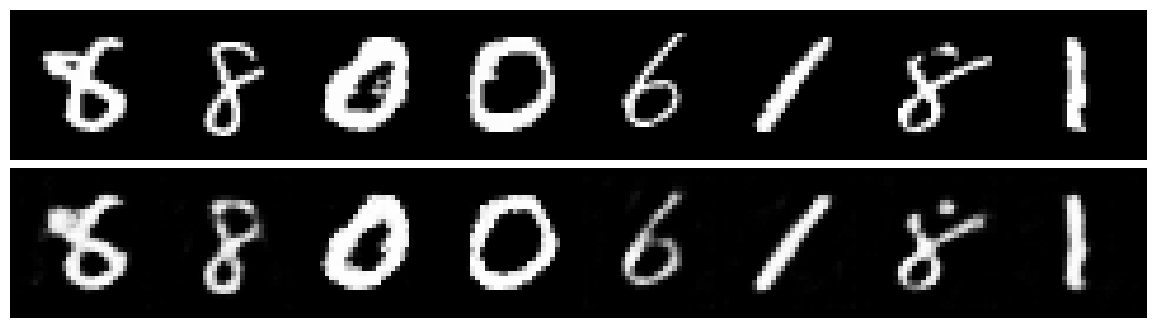

Epoch 2
Final Avg: enc_loss: 0.0272802151977888836207


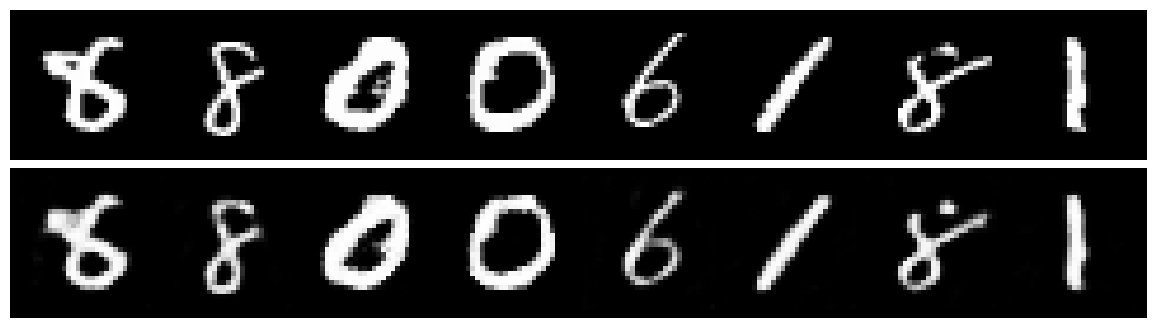

Epoch 3
Final Avg: g_loss: 0.7595231236298201, d_loss: 1.43586574650522504956


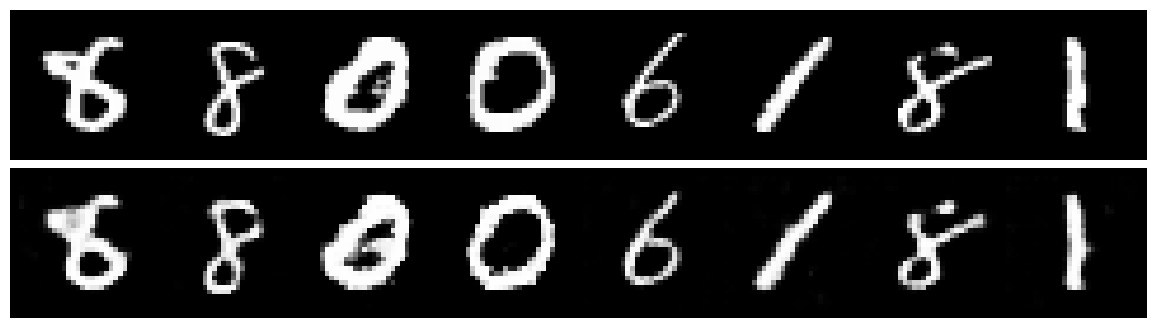

Epoch 4


KeyboardInterrupt: 

In [37]:
num_epochs = 10
enc_warmup_epochs = 1
test_imgs = next(iter(dataloader))[0][:8].to(device)
lr=0.0002
ecgen_optimiser = torch.optim.Adam(ecgenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(ecdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
loss2 = nn.MSELoss()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    ecdis_loss_sum = 0
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    for i, (images, _) in enumerate(dataloader):
        real_img = images.to(device)
        ecgenerator.train()
        batch_size = real_img.shape[0]

        if epoch < enc_warmup_epochs:
            enc_loss = enc_train_step(ecgenerator, ecgen_optimiser, loss2, images.to(device))
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                print('Step: {}/{}, enc_loss: {}'.format(i, len(dataloader), enc_loss), end='\x1b[1K\r')
            continue

        else:
            ecdis_loss = ecdis_train_step(batch_size, ecgenerator, ecdiscriminator, ecdis_optimiser, loss, real_img)
            ecgen_loss = ecgen_train_step(batch_size, ecgenerator, ecdiscriminator, ecgen_optimiser, loss, loss2, real_img)
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                print('Step: {}/{}, g_loss: {}, d_loss: {}'.format(i, len(dataloader), ecgen_loss, ecdis_loss), end='\x1b[1K\r')

    if epoch < enc_warmup_epochs:
        print('Final Avg: enc_loss: {}'.format(enc_loss_sum / len(dataloader))) # Print the loss values
    else:
        print('Final Avg: g_loss: {}, d_loss: {}'.format(ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader))) # Print the loss values
    
    ecgenerator.eval()
    sample_images = ecgenerator(test_imgs).cpu()

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, figsize=(16, 4))

    # Plot the test images on the first row
    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")

    # Plot the sample images on the second row
    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()